#Initializations

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os
import pickle as pkl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Lyon-BSA encoded spike data of shape (num samples, num iterations, num channels). For example, matlab converted TI46 dataset would have the shape (18000, 1000, 77) [num iterations = 1000, with decimation factor 12, to the best of my knowledge], and python converted google mini-speech dataset would have the shape (8000, 1378, 96)

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/tf_LSM/'
x_data = np.load(data_path + 'mini_speech_data_decimation_16_2.npy')
y_data = np.load(data_path + 'mini_speech_label_decimation_16_2.npy')

In [ ]:
print(x_data.shape)
print(y_data.shape)
print(y_data[1])

(8000, 1378, 96)
(8000,)
no


In [ ]:
print(x_data.dtype)

int8


In [ ]:
data_size_test = x_data.shape[0]//5

x_test=np.array(x_data[-data_size_test:])
y_test=np.array(y_data[-data_size_test:])
x_in_train=np.array(x_data[:-data_size_test])
y_in_train=np.array(y_data[:-data_size_test])

data_size = x_in_train.shape[0]

print(x_data.shape)

(8000, 1378, 96)


In [ ]:
a = 20
b = 20
c = 1
depth = 2

In [ ]:
print(len(np.unique(np.array(y_test))))

8


#Training

In [ ]:
import math
import random

#FLAG_global = "sup_stdp"
FLAG_global = "full_stdp"

Nx = a
Ny = b
Nz = c
N = Nx*Ny*Nz
LqW = 3
in_conn_density = 0.15
inh_fr = 0.2
lam = 9

in_size = x_data.shape[2]
labels = np.unique(np.array(y_test))


W_lsm = np.zeros((N,N))
W_lsm_sign = np.zeros((N,N))
W_in = np.zeros((in_size,N))
W_out = np.zeros((1,len(labels)))
W_lsm_mask = np.ones((N,N))

in_conn_range = np.int32(N*in_conn_density)
input_perm_i = np.arange(N)
random.shuffle(input_perm_i[in_conn_range:])

pos_conn = input_perm_i[:in_conn_range]
output_neurons = input_perm_i[-len(labels):]
for i in output_neurons:
  for j in output_neurons:
    if i!=j:
      W_lsm[i,j] = -LqW
output_dict = {}
for j in range(len(labels)):
  output_dict[labels[j]] = output_neurons[j]


for i in range(in_size):
  input_perm_i = np.arange(N)
  random.shuffle(input_perm_i[in_conn_range:-len(labels)])
  neg_conn = input_perm_i[-in_conn_range-len(labels):-len(labels)]
  for j in range(len(pos_conn)):
    W_in[i,pos_conn[j]] = 5*LqW*math.exp(-(j-(i*len(pos_conn)/in_size))**2/(5**2))
  for j in range(len(neg_conn)):
    #W_in[i,neg_conn[j]] = -2*LqW*math.exp(-(j-(i*len(neg_conn)/in_size))**2/(5**2))
    W_in[i,neg_conn[j]] = -LqW

for i in range(len(labels)):
  W_out[0,i] = LqW

input_perm = np.arange(N)
np.random.shuffle(input_perm) # first 0.2*N indices are inhibitory
inh_range = np.int32(inh_fr*N) # indices 0 to inh_range-1 are inhibitory

for i in range(N):
  posti = input_perm[i] # input_perm[i] is the post-neuron index
  zi = posti//(Nx*Ny)
  yi = (posti-zi*Nx*Ny)//Nx
  xi = (posti-zi*Nx*Ny)%Nx
  for j in range(N):
    prej = input_perm[j] # input_perm[j] is the pre-neuron index
    zj = prej//(Nx*Ny)
    yj = (prej-zj*Nx*Ny)//Nx
    xj = (prej-zj*Nx*Ny)%Nx
    D = ((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2)
    if i<inh_range and j<inh_range: # II connection, C = 0.3
      P = 0.3*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
        W_lsm_sign[prej,posti] = -1
    if i<inh_range and j>=inh_range: # EI connection, C = 0.1
      P = 0.1*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW
        W_lsm_sign[prej,posti] = 1
    if i>=inh_range and j<inh_range: # IE connection, C = 0.05
      P = 0.05*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
        W_lsm_sign[prej,posti] = -1
    if i>=inh_range and j>=inh_range: # EE connection, C = 0.2
      P = 0.2*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = 4*LqW
        W_lsm_sign[prej,posti] = 1

W_lsm_mask = np.where(W_lsm == 0, 0, 1) #Ensure that neuron can only connect to others in some fixed neighbourhood vicinity.

for i in range(N):
  W_lsm[i,i] = 0
  W_lsm_mask[i,i] = 0
  W_lsm_sign[i,i] = 0


for i in range(N):
  for j in range(N):
    a2 = i//Nx
    b2 = i%Nx
    c2 = j//Nx
    d2 = j%Nx
    sumdist = (a2-c2)**2 + (b2-d2)**2
    if sumdist <= 2:
      W_lsm_mask[i,j] = 1



num_iter = x_data.shape[1]
W_lsm_tf = tf.constant(W_lsm, dtype=tf.float32)
W_in_tf = tf.constant(W_in, dtype=tf.float32)

#print(N)

#eta = 0.1
#eta1 = 0.1
eta = 0.02
eta1 = 0.1
eta2 = 0.1
a1 = 0.1
a2 = 0.1
th = 0.4
#flags = ["no_stdp", "ll_stdp", "il_stdp", "full_stdp"]
flag = FLAG_global

batch_size = 200
A_new = 0.005
num_batches = data_size//batch_size
num_batches_test = data_size_test//batch_size
num_partitions = 4
LSM_out_train = np.zeros((x_in_train.shape[0],num_partitions*N))
LSM_out_test = np.zeros((x_test.shape[0],num_partitions*N))
#LSM_out_train2 = np.zeros((x_in_train.shape[0],num_iter, N))
#LSM_out_test2 = np.zeros((x_test.shape[0],num_iter,N))
#print("hi")
w_scale = 1
partition = num_iter//num_partitions

In [ ]:
from tqdm import tqdm


def run_LSM(Vm, SI, Sin, SinI, eta, eta1, a1, a2, in_W, W, sc_W, th, n_iter):
  Sliq = []
  global N
  count = np.zeros((batch_size, N))
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, sc_W*W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    toadd = Sout.numpy()
    count = np.add(count, toadd)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), count

# LSM with STDP in Liquid-Liquid (LL) connections
def run_LSM_LL_STDP(Vm, SI, Sin, SinI, spT, eta, eta1, a1, a2, in_W, W, th, n_iter, batch_s, Nin=0, Nrev=0, Ap=0.01, An=0.02, a3=0.1, eta2=0.1):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout

    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = W + dwp + dwn

    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), W, An

# LSM with STDP in Input-Liquid (IL) connections
def run_LSM_IL_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, th, n_iter, batch_s, Nin=0, Nrev=0, Ap=0.01, An=0.02, a3=0.1, eta2=0.1):
  Sliq = []
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    in_W = in_W + dwp + dwn

    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, An

# new version
# LSM with STDP in all (LL and IL) connections
def run_LSM_full_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, W_mask, th, n_iter, batch_s, W_sign, in_W_sign=1, Nin=0, Nrev=0, Ap=0.01, An=0.02, dw_in_scale=1, dw_lsm_scale=1, a3=0.1, eta2=0.1):
  Sliq = []
  global N
  count = np.zeros((batch_size, N))
  for i in tqdm(range(n_iter)):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    toadd = Sout.numpy()
    count = np.add(count, toadd)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    #dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    #dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    #in_W = in_W + dw_in_scale*(dwp + dwn)

    #in_W_check = in_W*in_W_sign
    #in_W = in_W*tf.cast(in_W_check>=0, dtype=tf.float32)

    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = (W + dw_lsm_scale*(dwp + dwn))*W_mask

    W_check = W*W_sign
    W = W*tf.cast(W_check>=0, dtype=tf.float32)

    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    spike_mult = 1
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - spike_mult*tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, W, An, count


def run_LSM_supervised_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, W_mask, th, n_iter, batch_s, W_sign, y_labels, in_W_sign=1, Nin=0, Nrev=0, Ap=0.01, An=0.02, dw_in_scale=1, dw_lsm_scale=1, a3=0.1, eta2=0.1):
  Sliq = []
  global N
  global output_neurons
  global output_dict
  count = np.zeros((batch_size, N))
  batch_outputs = []
  indic_matrix = []
  for i in range(len(y_labels)):
    zeros_vec = np.zeros(Vm.shape[1])
    batch_outputs.append(output_dict[y_labels[i]])
    zeros_vec[output_dict[y_labels[i]]] = 1
    indic_matrix.append(zeros_vec)
  indic_matrix = np.array(indic_matrix)
  #print(indic_matrix) #1s wherever single output neuron spikes
  indic2_matrix = 1 - indic_matrix #0s wherever single output neuron spikes
  #print(indic2_matrix)
  for i in tqdm(range(n_iter)):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Vm = np.multiply(Vm,indic2_matrix) + np.multiply(th,indic_matrix)
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    toadd = Sout.numpy()
    count = np.add(count, toadd)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    #dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    #dwn = -An*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    #in_W = in_W + dw_in_scale*(dwp + dwn)

    #in_W_check = in_W*in_W_sign
    #in_W = in_W*tf.cast(in_W_check>=0, dtype=tf.float32)

    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = -An*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = (W + dw_lsm_scale*(dwp + dwn))*W_mask

    W_check = W*W_sign
    W = W*tf.cast(W_check>=0, dtype=tf.float32)

    tau_astro = 10
    eta_astro = 1/tau_astro
    w_astro = 0.01
    spike_mult = 1
    An = An*(1-eta_astro) + (w_astro/tau_astro)*(tf.reduce_mean(tf.reduce_sum(Sout, axis=1)) - spike_mult*tf.reduce_mean(tf.reduce_sum(Sin[:,i,:], axis=1))) + Ap/tau_astro

    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, W, An, count


def run_LSM_symsup_STDP(Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, W_mask, th, n_iter, batch_s, W_sign, y_labels, in_W_sign=1, Nin=0, Nrev=0, Ap=0.01, An=0.02, dw_in_scale=1, dw_lsm_scale=1, a3=0.1, eta2=0.1):
  Sliq = []
  global N
  global output_neurons
  global output_dict
  count = np.zeros((batch_size, N))
  batch_outputs = []
  indic_matrix = []
  for i in range(len(y_labels)):
    zeros_vec = np.zeros(Vm.shape[1])
    batch_outputs.append(output_dict[y_labels[i]])
    zeros_vec[output_dict[y_labels[i]]] = 1
    indic_matrix.append(zeros_vec)
  indic_matrix = np.array(indic_matrix)
  #print(indic_matrix) #1s wherever single output neuron spikes
  indic2_matrix = 1 - indic_matrix #0s wherever single output neuron spikes
  #print(indic2_matrix)
  for i in tqdm(range(n_iter)):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, W) + tf.matmul(SinI, in_W))
    Vm = np.multiply(Vm,indic2_matrix) + np.multiply(th,indic_matrix)
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    toadd = Sout.numpy()
    count = np.add(count, toadd)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    spT = (1-eta2)*spT + a3*Sout
    spT_in = (1-eta2)*spT_in + a3*Sin[:,i,:]

    #dwp = Ap*tf.matmul(tf.transpose(spT_in), Sout)/batch_s
    #dwn = Ap*tf.matmul(tf.transpose(Sin[:,i,:]), spT)/batch_s
    #in_W = in_W + dw_in_scale*(dwp + dwn)

    dwp = Ap*tf.matmul(tf.transpose(spT), Sout)/batch_s
    dwn = Ap*tf.matmul(tf.transpose(Sout), spT)/batch_s
    W = (W + dw_lsm_scale*(dwp + dwn))*W_mask

    W_check = W*W_sign
    W = W*tf.cast(W_check>=0, dtype=tf.float32)
    """
    #in_W = tf.linalg.normalize(in_W, ord=1, axis=0, name=None)[0]
    W = tf.linalg.normalize(W, ord=1, axis=0, name=None)[0]
    #in_W_Nin = tf.cast(tf.math.count_nonzero(in_W, 0), dtype=tf.float32)
    W_Nin = tf.cast(tf.math.count_nonzero(W, 0), dtype=tf.float32)
    #in_W = LqW*(in_W_Nin*in_W)
    W = LqW*(W_Nin*W)
    """
    #in_W = tf.linalg.normalize(in_W, ord=1, axis=1, name=None)[0]
    W = tf.linalg.normalize(W, ord=1, axis=0, name=None)[0]
    #in_W_Nin = tf.cast(tf.math.count_nonzero(in_W, 1, keepdims = True), dtype=tf.float32)
    W_Nin = tf.cast(tf.math.count_nonzero(W, 0, keepdims = True), dtype=tf.float32)
    #print(in_W_Nin.shape)
    #in_W = LqW*(in_W_Nin*in_W)
    W = LqW*(W_Nin*W)
    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), in_W, W, An, count



100%|██████████| 1378/1378 [00:10<00:00, 137.06it/s]


batch 1


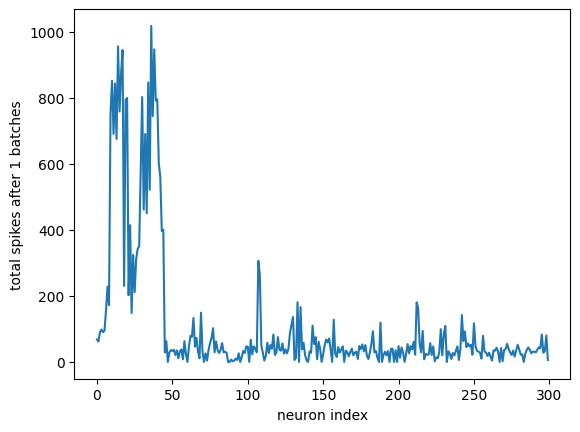

completed:  0.03125


100%|██████████| 1378/1378 [00:10<00:00, 137.76it/s]


batch 5


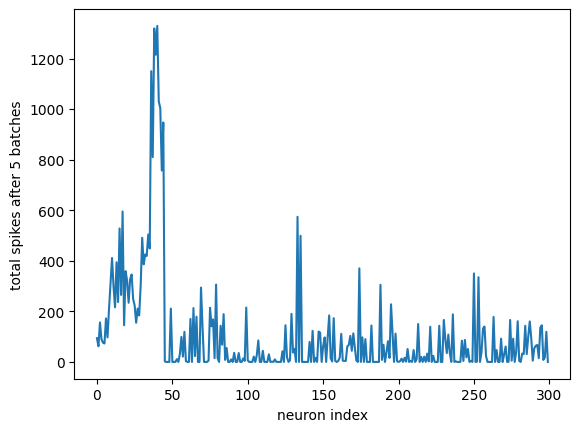

completed:  0.15625


100%|██████████| 1378/1378 [00:10<00:00, 136.83it/s]


batch 9


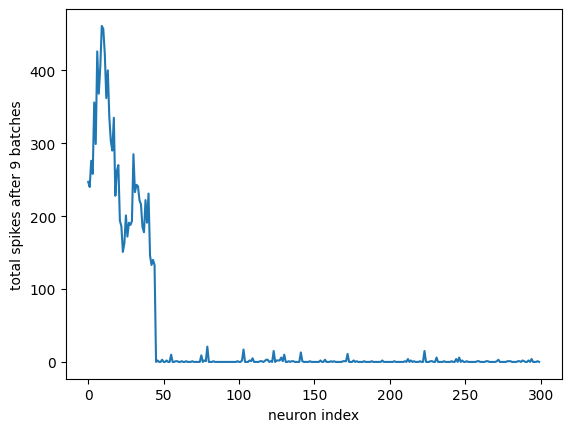

completed:  0.28125


100%|██████████| 1378/1378 [00:10<00:00, 127.37it/s]


batch 13


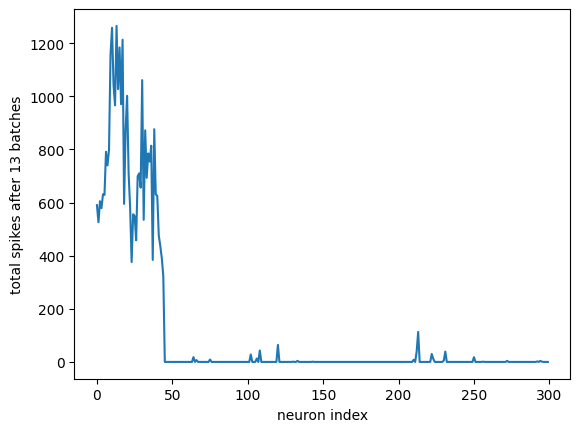

completed:  0.40625


100%|██████████| 1378/1378 [00:10<00:00, 135.18it/s]


batch 17


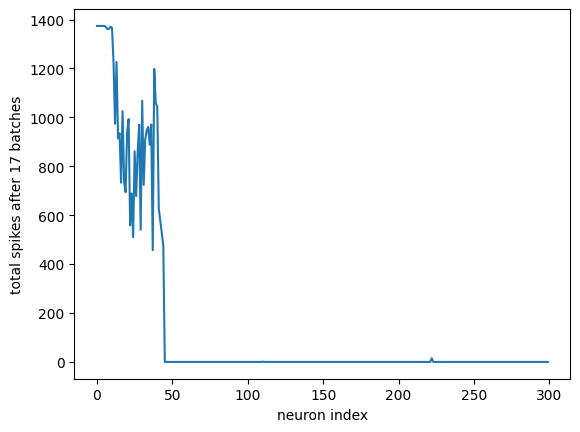

completed:  0.53125


100%|██████████| 1378/1378 [00:10<00:00, 135.76it/s]


batch 21


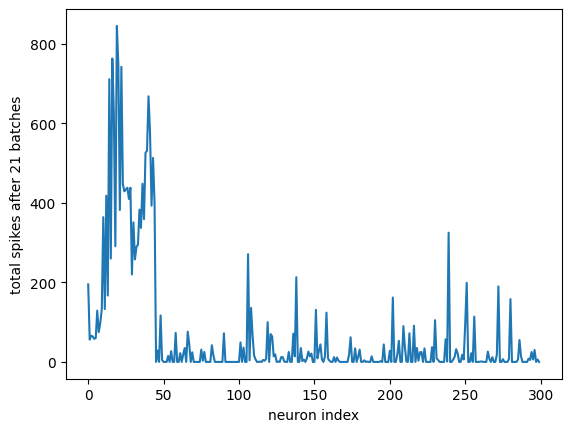

completed:  0.65625


100%|██████████| 1378/1378 [00:10<00:00, 136.19it/s]


batch 25


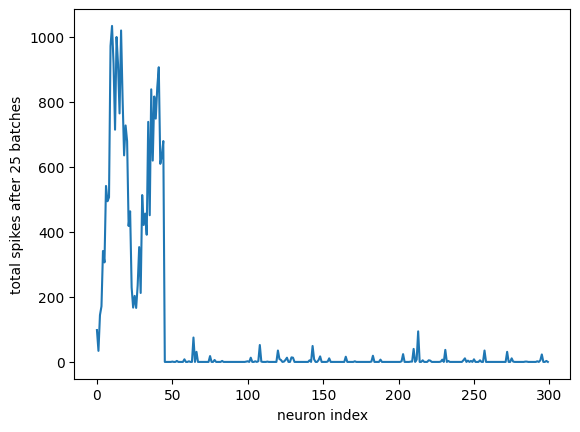

completed:  0.78125


100%|██████████| 1378/1378 [00:10<00:00, 135.21it/s]


batch 29


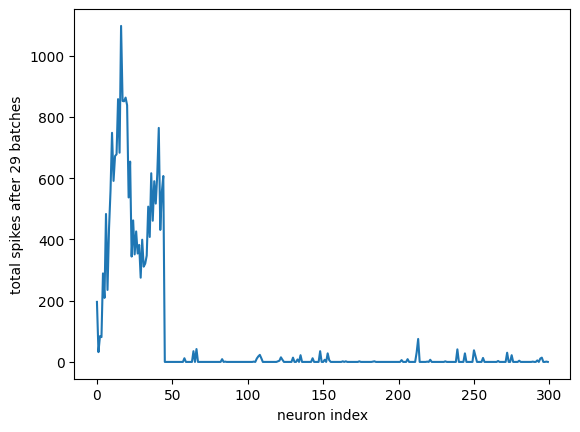

completed:  0.90625


100%|██████████| 1378/1378 [00:09<00:00, 139.05it/s]


helo there


In [ ]:


for ba in range(num_batches):
  if((ba-1)%4==0):
    indic1=0
    indic2=0
    for kl in range(1):
      x= np.arange(len(count[kl]))
      #print(count[kl], y_data[batch_size*num_batches + kl] )
      #print(count[kl][output_dict[y_data[batch_size*num_batches + kl]]])
      print("batch", ba)
      plt.plot(x, count[kl])
      plt.xlabel('neuron index', fontsize=10)
      plt.ylabel('total spikes after '+str(ba)+' batches', fontsize=10)
      plt.show()
    print("completed: ", ba/num_batches)
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  spT_in_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)

  batch_in_full = x_in_train[ba*batch_size:(ba+1)*batch_size]
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)
  y_in_full = y_in_train[ba*batch_size:(ba+1)*batch_size]

  W_lsm_tf = tf.constant(W_lsm, dtype=tf.float32)

  # Try multimodal W_lsm from MNIST
  #W_lsm_tf = tf.constant(W_lsm_multi, dtype=tf.float32)

  W_in_tf = tf.constant(W_in, dtype=tf.float32)

  if flag == "no_stdp":
    #Vm, SI, Sin, SinI, eta, eta1, a1, a2, in_W, W, sc_W, th, n_iter
    S_liq, count = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)
  elif flag == "il_stdp":
    #Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, th, n_iter, batch_s, Nin=0, Nrev=0, Ap=0.01, An=0.02, a3=0.1, eta2=0.1
    S_liq, in_wf, a_new = run_LSM_IL_STDP(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, spT_tf, spT_in_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, th, num_iter, batch_size)
    W_in = in_wf
    a2 = a_new
  elif flag == "ll_stdp":
    #Vm, SI, Sin, SinI, spT, eta, eta1, a1, a2, in_W, W, th, n_iter, batch_s, Nin=0, Nrev=0, Ap=0.01, An=0.02, a3=0.1, eta2=0.1
    S_liq, lsm_wf, a_new = run_LSM_LL_STDP(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, spT_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, th, num_iter, batch_size)
    W_lsm = lsm_wf
    a2 = a_new
  elif flag == "full_stdp":
    #Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, W_mask, th, n_iter, batch_s, W_sign, in_W_sign=1, Nin=0, Nrev=0, Ap=0.01, An=0.02, dw_in_scale=1, dw_lsm_scale=1, a3=0.1, eta2=0.1
    S_liq, in_wf, lsm_wf, a_new, count = run_LSM_full_STDP(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, spT_tf, spT_in_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, W_lsm_mask, th, num_iter, batch_size, W_lsm_sign, An = A_new)
    W_in = in_wf
    W_lsm = lsm_wf
    #A_new = a_new
  elif flag == "sup_stdp":
    #Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, W_mask, th, n_iter, batch_s, W_sign, in_W_sign=1, Nin=0, Nrev=0, Ap=0.01, An=0.02, dw_in_scale=1, dw_lsm_scale=1, a3=0.1, eta2=0.1
    S_liq, in_wf, lsm_wf, a_new, count = run_LSM_supervised_STDP(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, spT_tf, spT_in_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, W_lsm_mask, th, num_iter, batch_size, W_lsm_sign, An = A_new, y_labels = y_in_full)
    W_in = in_wf
    W_lsm = lsm_wf
    A_new = a_new
  elif flag == "symsup_stdp":
    #Vm, SI, Sin, SinI, spT, spT_in, eta, eta1, a1, a2, in_W, W, W_mask, th, n_iter, batch_s, W_sign, in_W_sign=1, Nin=0, Nrev=0, Ap=0.01, An=0.02, dw_in_scale=1, dw_lsm_scale=1, a3=0.1, eta2=0.1
    S_liq, in_wf, lsm_wf, a_new, count = run_LSM_symsup_STDP(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, spT_tf, spT_in_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, W_lsm_mask, th, num_iter, batch_size, W_lsm_sign, An = A_new, y_labels = y_in_full)
    W_in = in_wf
    W_lsm = lsm_wf
    A_new = a_new
  else:
    S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)






  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)

  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)
  #LSM_out_train2[b*batch_size:(b+1)*batch_size] = S_liq.numpy()
  LSM_out_train[b*batch_size:(b+1)*batch_size] = S_liq_c.numpy()

for ba in range(num_batches_test):
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  batch_in_full = x_test[ba*batch_size:(ba+1)*batch_size]
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)

  S_liq, count = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)

  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)

  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)
  #LSM_out_test2[b*batch_size:(b+1)*batch_size] = S_liq.numpy()

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)

  LSM_out_test[ba*batch_size:(ba+1)*batch_size] = S_liq_c.numpy()

with open(data_path + f"LSM_out_train_{flag}.pkl","wb") as f:
  pkl.dump(LSM_out_train, f)
with open(data_path + f"LSM_out_test_{flag}.pkl","wb") as f:
  pkl.dump(LSM_out_test, f)
with open(data_path + f"Weights_LSM_{flag}.pkl","wb") as f:
  pkl.dump(W_lsm, f)
with open(data_path + f"Weights_in_{flag}.pkl","wb") as f:
  pkl.dump(W_in, f)
with open(data_path + f"An_{flag}.pkl","wb") as f:
  pkl.dump(A_new, f)

#with open(data_path + f"LSM_out_train2_{flag}.pkl","wb") as f:
#  pkl.dump(LSM_out_train2, f)
#with open(data_path + f"LSM_out_test2_{flag}.pkl","wb") as f:
#  pkl.dump(LSM_out_test2, f)

with open(data_path + f"x_data.pkl","wb") as f:
  pkl.dump(x_data, f)
with open(data_path + f"y_data.pkl","wb") as f:
  pkl.dump(y_data, f)
with open(data_path + f"x_test.pkl","wb") as f:
  pkl.dump(x_test, f)
with open(data_path + f"y_test.pkl","wb") as f:
  pkl.dump(y_test, f)
with open(data_path + f"x_in_train.pkl","wb") as f:
  pkl.dump(x_in_train, f)
with open(data_path + f"y_in_train.pkl","wb") as f:
  pkl.dump(y_in_train, f)

print("helo there")





tf.Tensor(
[-9.195841  -8.642937  -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.        -8.123304  -9.216386
 -0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.         0.         0.
 -0.         0.        -0.        -0.         0.        -0.
  0.        -0.         0.        -0.        -0.         0.
 -0.         0.        -0.         0.         0.        -0.
 -0.        -0.         0.        -0.        -0.         0.
 -0.         0.        -0.         0.        -0.        -0.
  0.        -0.        -0.         0.         0.         0.
  0.         0.        -0.         0.         0.         0.
  0.        -0.         0.         0.         0.         0.
  0.         0.        

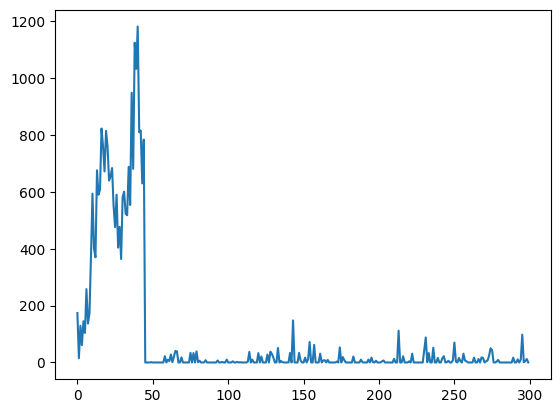

[1.150e+02 4.300e+01 1.220e+02 7.000e+01 1.310e+02 1.280e+02 9.090e+02
 2.020e+02 8.100e+02 1.021e+03 1.183e+03 9.930e+02 1.026e+03 1.097e+03
 1.213e+03 9.640e+02 1.278e+03 1.163e+03 1.101e+03 1.192e+03 1.171e+03
 9.700e+02 1.072e+03 8.900e+02 8.960e+02 8.190e+02 6.510e+02 4.280e+02
 5.750e+02 2.070e+02 6.370e+02 3.710e+02 4.690e+02 3.770e+02 6.210e+02
 4.520e+02 6.470e+02 4.790e+02 7.020e+02 8.000e+02 8.160e+02 7.820e+02
 6.340e+02 7.430e+02 7.440e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 4.000e+00
 0.000e+00 1.000e+01 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 2.200e+01 0.000e+00 3.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00
 0.000

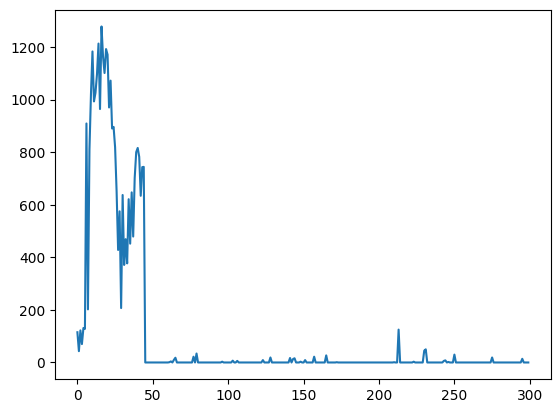

[3.020e+02 1.590e+02 1.790e+02 1.670e+02 1.940e+02 1.650e+02 2.150e+02
 2.920e+02 1.980e+02 4.860e+02 4.850e+02 4.910e+02 4.000e+02 7.460e+02
 4.660e+02 6.790e+02 4.190e+02 6.340e+02 2.720e+02 4.040e+02 4.650e+02
 4.090e+02 2.720e+02 3.690e+02 3.930e+02 5.220e+02 5.890e+02 8.730e+02
 7.870e+02 9.340e+02 1.062e+03 9.820e+02 9.540e+02 1.012e+03 8.200e+02
 9.960e+02 6.930e+02 7.380e+02 7.780e+02 5.870e+02 4.440e+02 3.120e+02
 1.560e+02 2.280e+02 1.560e+02 1.000e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 4.500e+01 0.000e+00 0.000e+00 3.300e+01 0.000e+00 4.400e+01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.500e+01 8.000e+00
 0.000e+00 0.000e+00 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00 9.300e+01 0.000e+00
 1.400e+01 5.000e+00 0.000e+00 0.000e+00 9.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

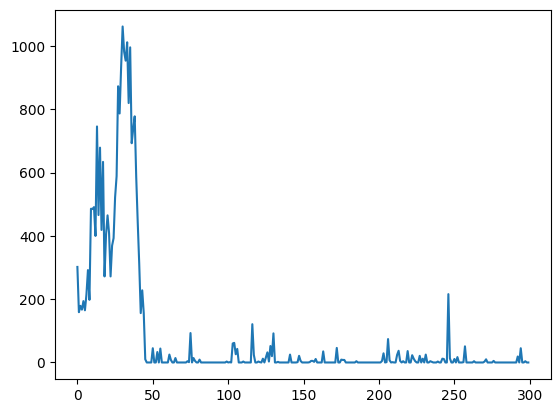

[480. 337. 481. 379. 437. 390. 428. 395. 293. 471. 569. 275. 339. 480.
 352. 459. 462. 551. 483. 584. 536. 457. 452. 478. 423. 466. 463. 468.
 444. 320. 549. 363. 367. 393. 392. 408. 447. 466. 628. 616. 625. 545.
 586. 463. 589.   0.   0.   0.   0.   4.  24.   2.   0.  31.   0.  46.
   2.   0.   9.   0.   1.  21.   3.   0.  26.  10.   1.   0.   0.  13.
   1.   0.   0.   0.   0.  27.  19.  14.   0.  24.   0.   8.   0.   8.
   1.   0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  10.   4.   0.   0.  16.  17.  13.  19.   0.   0.   0.   0.   0.
   0.  11.   0.   0.   8.   2.   0.   0.   4.   0.   4.  18.   2.   9.
  15.   0.  25.  17.  30.   0.   0.   8.   0.  11.   0.   0.   0.   0.
   0.  28.   0.   8.   2.   0.   4.   7.  15.   0.   1.   1.   0.   2.
   0.  35.   0.  32.   0.   0.   0.   0.   0.  57.   0.   0.   0.   0.
   8.   0.   0.   1.   6.   0.  16.   0.  26.   0.   2.   0.   0.   0.
   1.   1.   0.   0.   0.   0.  25.   0.   0.   0.   0.   0.   0.   0.
  10. 

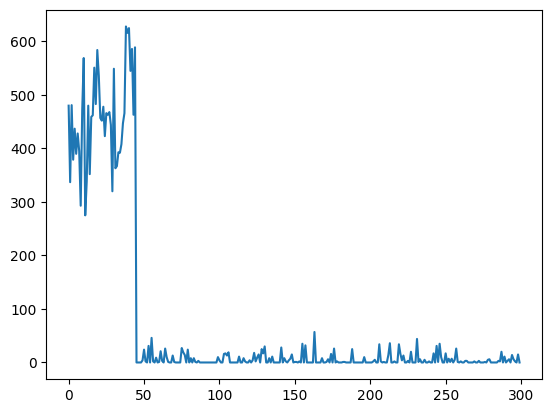

[435. 106. 161. 108. 115.  88. 119. 125.  90. 299. 469. 278. 306. 440.
 450. 533. 702. 800. 581. 969. 948. 660. 921. 754. 809. 586. 593. 416.
 454. 264. 481. 343. 341. 338. 484. 396. 639. 557. 810. 839. 971. 654.
 725. 689. 715.   0.   0.   0.   5.   1.   0.   0.   0.   0.   0.  27.
   0.   0.  62.   0.  22.  11.   8.   0.  57.   0.  60.   0.   0.  21.
   0.   0.   2.   0.   0.  32.   6.  39.   3.   8.   0.   0.   0.   3.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  11.   0.   0.   0.   0.   0.   0.  30.   7.   7.   0.   0.  11.
   0.   0.   5.   2.  16.   0.   0.   0.   6.   0.   7.   0.  18.   0.
  45.   0.   3.  13.  10.   0.   0.  91.   0.  35.  14.  12.   0.   0.
   0.   0.   0.  73.   4.   2.   0.   0.  66.   0.   0.   2.  23.  20.
  39.   1.   0.  27.   7.   0.  12.  29.   0.   0.   0.  19.   7.   0.
   0.   0.   0.   0.   0.   0.  54.   0.  17.   0.   5.   0.   0.   0.
   1.   0.   0.   0.   0.   1.  28.   0.   0.   0.   0.   0.   0.   0.
  18. 

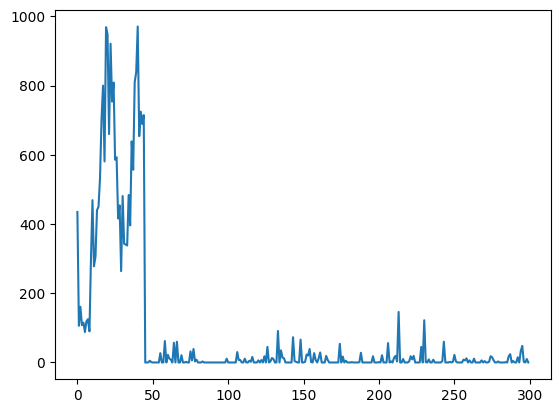

In [ ]:
flag = FLAG_global
#print(output_dict)
with open(data_path + f"Weights_LSM_{flag}.pkl","rb") as f:
  W_lsm_tf = pkl.load(f)
with open(data_path + f"Weights_in_{flag}.pkl","rb") as f:
  W_in_tf = pkl.load(f)
with open(data_path + f"An_{flag}.pkl","rb") as f:
  A_new = pkl.load(f)

print(W_lsm_tf[0])
print(W_in_tf[0])
print(W_lsm_tf.shape)
print(W_in_tf.shape)

print(output_dict)
for ba in range(num_batches_test):
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  batch_in_full = x_test[ba*batch_size:(ba+1)*batch_size]
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)

  if True:
      S_liq, count = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)
      #S_liq, dummy1, dummy2, dummy3, count = run_LSM_full_STDP(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, spT_tf, spT_in_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, W_lsm_mask, th, num_iter, batch_size, W_lsm_sign)

      indic1=0
      indic2=0
      if False:
        for kl in range(count.shape[0]):
          if y_data[batch_size*num_batches + kl] == "no" and indic1==0:
            x= np.arange(len(count[kl]))
            print(count[kl], y_data[batch_size*num_batches + kl] )
            print(count[kl][output_dict[y_data[batch_size*num_batches + kl]]])
            indic1 = 1
            plt.plot(x, count[kl])
            plt.show()
          if y_data[batch_size*num_batches + kl] == "go" and indic2==0:
            x= np.arange(len(count[kl]))
            print(count[kl], y_data[batch_size*num_batches + kl] )
            indic2 = 1
            plt.plot(x, count[kl])
            plt.show()
          if indic1 ==1 and indic2==1:
            break
        break
      else:
        for kl in range(5):
          x= np.arange(len(count[kl]))
          print(count[kl], y_data[batch_size*num_batches + kl] )
          print(count[kl][output_dict[y_data[batch_size*num_batches + kl]]])
          indic1 = 1
          plt.plot(x, count[kl])
          plt.show()
        break


  else:
    S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)

  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)

  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)
  #LSM_out_test2[b*batch_size:(b+1)*batch_size] = S_liq.numpy()


In [ ]:
print(np.sum(batch_in_full[0]))

22643


In [ ]:
print("mean LSM spiking (train) : ", np.mean(LSM_out_train))
print("mean LSM spiking (test) : ", np.mean(LSM_out_test))

print("mean input spiking (train) : ", np.mean(x_data))
print("mean input spiking (test) : ", np.mean(x_test))

print(a,b,c)

mean LSM spiking (train) :  0.0017796163405996292
mean LSM spiking (test) :  0.05508129543929827
mean input spiking (train) :  0.1725877847952951
mean input spiking (test) :  0.17318897972605224
10 10 3


In [ ]:
from tqdm import tqdm
import tensorflow as tf

Nx = a
Ny = b
Nz = c
N = Nx*Ny*Nz
print(N)

batch_size = 200
def run_LSM(Vm, SI, Sin, SinI, eta, eta1, a1, a2, in_W, W, sc_W, th, n_iter):
  Sliq = []
  global N
  count = np.zeros((batch_size, N))
  for i in range(n_iter):
    Vm = (1-eta)*Vm + a1*(tf.matmul(SI, sc_W*W) + tf.matmul(SinI, in_W))
    Sout = tf.cast(Vm>=th, dtype=tf.float32)
    toadd = Sout.numpy()
    count = np.add(count, toadd)
    Vm = Vm*tf.cast(Vm<th, dtype=tf.float32)
    SinI = (1-eta1)*SinI + a2*Sin[:,i,:]
    SI = (1-eta1)*SI + a2*Sout
    Sliq.append(Sout)
  return tf.stack(Sliq, axis=1), count


import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os
import pickle as pkl


flag = FLAG_global
eta = 0.1
eta1 = 0.1
a1 = 0.1
a2 = 0.1
th = 0.4




from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/tf_LSM/'
x_data = np.load(data_path + 'mini_speech_data_decimation_16_2.npy')
y_data = np.load(data_path + 'mini_speech_label_decimation_16_2.npy')
data_size_test = x_data.shape[0]//5
num_iter = x_data.shape[1]

x_test=np.array(x_data[-data_size_test:])
y_test=np.array(y_data[-data_size_test:])
x_in_train=np.array(x_data[:-data_size_test])
y_in_train=np.array(y_data[:-data_size_test])
num_partitions = 4
data_size = x_in_train.shape[0]
in_size = x_data.shape[2]

batch_size = 200
num_batches = data_size//batch_size
num_batches_test = data_size_test//batch_size


with open(data_path + f"Weights_LSM_{flag}.pkl","rb") as f:
  W_lsm_tf = pkl.load(f)
with open(data_path + f"Weights_in_{flag}.pkl","rb") as f:
  W_in_tf = pkl.load(f)
with open(data_path + f"An_{flag}.pkl","rb") as f:
  A_new = pkl.load(f)

#print(np.max(W_in_tf.numpy()))
#print(W_in_tf.shape)


print("An is : ", A_new)

print(W_in_tf)
LSM_out_train2 = np.zeros((x_in_train.shape[0],num_partitions*N))

num_batches = data_size//batch_size
num_batches_test = data_size_test//batch_size
num_partitions = 4
print("hi")
w_scale = 1
partition = num_iter//num_partitions

for ba in range(num_batches):
  if(ba%4==0):
    print("completed: ", ba/num_batches)
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  spT_in_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)

  batch_in_full = x_in_train[ba*batch_size:(ba+1)*batch_size]
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)


  #Vm, SI, Sin, SinI, eta, eta1, a1, a2, in_W, W, sc_W, th, n_iter
  S_liq, count = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)

  if b==0:
    with open(data_path + f"saved_spikes.pkl","wb") as f:
      pkl.dump(S_liq, f)

  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)

  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)
  #LSM_out_train2[b*batch_size:(b+1)*batch_size] = S_liq.numpy()
  LSM_out_train2[ba*batch_size:(ba+1)*batch_size] = S_liq_c.numpy()

with open(data_path + f"LSM_out_train2_{flag}.pkl","wb") as f:
  pkl.dump(LSM_out_train2, f)
#  break

#neuronSpikes = S_liq.numpy()

#with open(data_path + "saved_spikes.pkl", "wb") as f:
#  pkl.dump(neuronSpikes,f)





300
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
An is :  0.005
tf.Tensor(
[[1.5000000e+01 1.4411841e+01 1.2782157e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.4868742e+01 1.4831616e+01 1.3657122e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.4481818e+01 1.4997657e+01 1.4337722e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.4537866e-32 4.5680505e-31 1.3250052e-29 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.8100494e-33 9.1670627e-32 2.7605964e-30 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [5.3369501e-34 1.8075713e-32 5.6513758e-31 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]], shape=(96, 300), dtype=float32)
hi
completed:  0.0
completed:  0.125
completed:  0.25
completed:  0.375
completed:  0.5
completed:  0.625
completed:  0.75
completed:  0.875


#Area Exploration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


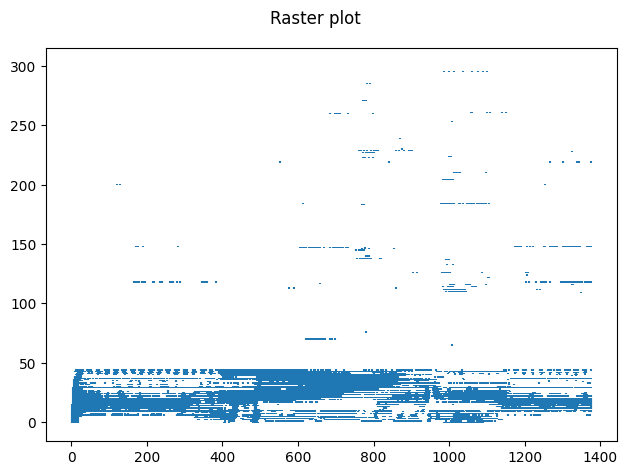

In [ ]:
import pickle as pkl
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Colab Notebooks/tf_LSM/'

with open(data_path + "saved_spikes.pkl", "rb") as f:
  neuronSpikes = pkl.load(f)
  neuronSpikes = neuronSpikes.numpy()

num_in_batch = 7

raster = []
for i in range(neuronSpikes.shape[2]):
  this_neuron = []
  for k in range(0,neuronSpikes.shape[1]): #1378
    if neuronSpikes[num_in_batch][k][i] == 1:
      this_neuron.append(k)
  raster.append(this_neuron)



from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1)
ax.eventplot(raster)
fig.suptitle("Raster plot")
fig.tight_layout()
fig.savefig("Question_2_raster_plot")
plt.show()

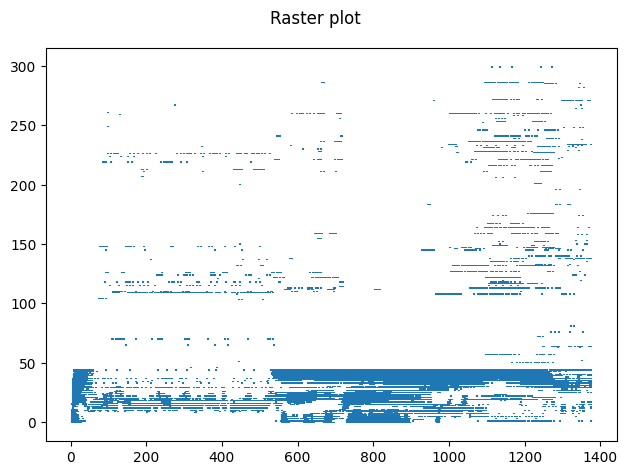

In [ ]:
num_in_batch = 1

raster = []
for i in range(neuronSpikes.shape[2]):
  this_neuron = []
  for k in range(0,neuronSpikes.shape[1]): #1378
    if neuronSpikes[num_in_batch][k][i] == 1:
      this_neuron.append(k)
  raster.append(this_neuron)



from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1)
ax.eventplot(raster)
fig.suptitle("Raster plot")
fig.tight_layout()
fig.savefig("Question_2_raster_plot")
plt.show()


In [ ]:
with open(data_path + f"y_in_train.pkl","rb") as f:
  y_in_train = pkl.load(f)
for i in range(50):
  print(y_in_train[i], i)


down 0
no 1
down 2
left 3
up 4
go 5
down 6
down 7
stop 8
left 9
go 10
down 11
left 12
up 13
yes 14
go 15
left 16
stop 17
down 18
go 19
down 20
stop 21
left 22
up 23
down 24
go 25
down 26
right 27
yes 28
stop 29
yes 30
no 31
up 32
go 33
up 34
go 35
yes 36
down 37
up 38
no 39
stop 40
left 41
left 42
right 43
down 44
up 45
right 46
right 47
left 48
down 49


In [ ]:
new_boxes = []
num_bins = 3
for i in range(N):
  Nx = i//a
  Ny = i%a
  new_x = Nx//(a//num_bins)
  new_y = Ny//(b//num_bins)
  new_box = new_x*num_bins**2 + new_y*num_bins
  new_boxes.append(new_box)


In [ ]:
num_in_batch = 16
box_vec = [0 for x in range(num_bins**3)]
raster = []
for i in range(neuronSpikes.shape[2]): #number of neurons
  for k in range(0,neuronSpikes.shape[1]): #1378
    if neuronSpikes[num_in_batch][k][i] == 1:
      box_vec[new_boxes[i]] = box_vec[new_boxes[i]]+1

print(box_vec)
print([i for i in range(len(box_vec)) if box_vec[i]>1500])


IndexError: ignored

In [ ]:
num_in_batch = 38
total_spikes = np.sum(x_in_train[num_in_batch], axis=1)
differ = [total_spikes[i+5]- total_spikes[i] for i in range(1370)]
a= np.arange(1370)
plt.plot(a, differ)
plt.show()

In [ ]:
import numpy as np
corr_change = []
total_timediv = 15
time_window = neuronSpikes.shape[1]//total_timediv

with open(data_path + f"filenames.pkl","rb") as f:
    filenames = pkl.load(f)

def ret_matrix_of_spacetime(num_in_batch, total_timediv):
  global filenames
  filename1 = filenames[num_in_batch]
  box_vec1 = [0 for x in range(num_bins**3)]
  for j in range(100):
    for i in range(neuronSpikes.shape[2]): #number of neurons
      for k in range(j*100,(j+1)*100): #1378
        if neuronSpikes[num_in_batch][k][i] == 1:
          box_vec1[new_boxes[i]] = box_vec1[new_boxes[i]]+1
      print(box_)



for j in range(total_timediv):
  num_in_batch = 3
  filename1 = filenames[num_in_batch]
  box_vec1 = [0 for x in range(num_bins**3)]
  for i in range(neuronSpikes.shape[2]): #number of neurons
    for k in range(j*total_timediv,(j+1)*total_timediv): #1378
      if neuronSpikes[num_in_batch][k][i] == 1:
        box_vec1[new_boxes[i]] = box_vec1[new_boxes[i]]+1

  num_in_batch = 36
  filename2 = filenames[num_in_batch]
  box_vec2 = [0 for x in range(num_bins**3)]
  for i in range(neuronSpikes.shape[2]): #number of neurons
    for k in range(j*total_timediv,(j+1)*total_timediv): #1378
      if neuronSpikes[num_in_batch][k][i] == 1:
        box_vec2[new_boxes[i]] = box_vec2[new_boxes[i]]+1
  #print(box_vec1)
  #print(box_vec2)
  corr = np.corrcoef(box_vec1, box_vec2)
  corr_change.append(corr[0][1])

print(filename1, filename2)
print(corr_change)

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os

DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [ ]:
from IPython.display import Audio
#wn = Audio(str(filename1), autoplay=True)
#display(wn)
#wn = Audio(str(filename2), autoplay=True)
#display(wn)
from scipy.io.wavfile import read
a = read(str(filenames[num_in_batch]))
b = np.array(a[1],dtype=float)
print(b.shape)

wn = Audio(b[-10000:], autoplay=True, rate = 16000)
display(wn)


In [ ]:
neuronSpikes[1].sum()

linear classifier weights take of all neurons.
see assigned weight matrix 1728*10
build a weighted spike rate.

top n most imp neurons in this area

build small bins, compare correlations over time, how they increase or decrease.

#Linear models

In [ ]:
with open(data_path + f"LSM_out_train2_{flag}.pkl","rb") as f:
  LSM_out_train2 = pkl.load(f)
with open(data_path + f"LSM_out_test_{flag}.pkl","rb") as f:
  LSM_out_test = pkl.load(f)
print(LSM_out_train2)
print(LSM_out_test)
print(y_in_train.shape)

In [ ]:
print(LSM_out_test.sum())

In [ ]:
#print(LSM_out_train[-1000:].shape)
print(LSM_out_test.shape)
print(y_in_train[-1000:].shape)

In [ ]:
from sklearn import linear_model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier


print(LSM_out_train2.sum())
print("training linear model on LSM")
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
#clf = MLPClassifier(solver='lbfgs', alpha=1.5, hidden_layer_sizes=(32,15), random_state=1)
#clf.fit(LSM_out_train[-500:], y_in_train[-500:])
clf.fit(LSM_out_train2, y_in_train)

train_score = clf.score(LSM_out_train2, y_in_train)
print("train score = " + str(train_score))

score = clf.score(LSM_out_test, y_test)
print("test score = " + str(score))

test_predict = clf.predict(LSM_out_test)
cm = confusion_matrix(y_test, test_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

#print("training linear model on direct input")
#clf2 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
#clf2.fit(np.mean(x_in_train, axis=(1)), y_in_train)

#score2 = clf2.score(np.mean(x_test, axis=(1)), y_test)
#print("test score without LSM = " + str(score2))

In [ ]:
print(LSM_out_test)

#Intuition plotting

In [ ]:
leng = 10
with open(data_path + "saved_spikes.pkl", "rb") as f:
  neuronSpikes = pkl.load(f)
  neuronSpikes = neuronSpikes.numpy()
num_in_batch = 46
print(neuronSpikes.shape[2])
image_vec = [[0 for x1 in range(leng)] for x2 in range(leng)]
for i in range(neuronSpikes.shape[2]): #number of neurons
  for k in range(0,neuronSpikes.shape[1]): #1378
    if neuronSpikes[num_in_batch][k][i] == 1:
      Nx1 = i//leng
      Ny1 = i%leng
      image_vec[Nx1][Ny1] = image_vec[Nx1][Ny1] + 1
image_vecnp = np.array(image_vec)

from matplotlib import pyplot as plt
plt.imshow(image_vecnp, cmap='gray')
plt.show()